#### Get all the character anchor list

In [3]:
import requests
from bs4 import BeautifulSoup as bs


In [4]:
base_url = "https://genshin.gg"
r = requests.get(base_url)
soup = bs(r.text , 'html.parser')
d_charlist = soup.find('div', attrs={"class":"character-list"})
a_charlist = [c['href'] for c in d_charlist.find_all('a' , attrs={'class':"character-portrait"})]

# remove amber and hydro traveler outliers (NO TEAMS LOL)
a_charlist.remove("/characters/amber/")
a_charlist.remove('/characters/traveler(hydro)/')


print(a_charlist)

['/characters/albedo/', '/characters/alhaitham/', '/characters/aloy/', '/characters/ayaka/', '/characters/ayato/', '/characters/baizhu/', '/characters/childe/', '/characters/chiori/', '/characters/cyno/', '/characters/dehya/', '/characters/diluc/', '/characters/eula/', '/characters/furina/', '/characters/ganyu/', '/characters/hutao/', '/characters/itto/', '/characters/jean/', '/characters/kazuha/', '/characters/keqing/', '/characters/klee/', '/characters/kokomi/', '/characters/lyney/', '/characters/mona/', '/characters/nahida/', '/characters/navia/', '/characters/neuvillette/', '/characters/nilou/', '/characters/qiqi/', '/characters/raiden/', '/characters/shenhe/', '/characters/tighnari/', '/characters/traveler(anemo)/', '/characters/traveler(dendro)/', '/characters/traveler(electro)/', '/characters/traveler(geo)/', '/characters/venti/', '/characters/wanderer/', '/characters/wriothesley/', '/characters/xianyun/', '/characters/xiao/', '/characters/yaemiko/', '/characters/yelan/', '/char

create the list of characters and anchor to name fun def

In [5]:
charlist = [c.split('/characters/')[1][:-1] for c in a_charlist]
print(charlist)

def atot(anchor):
    return anchor.split('/characters/')[1][:-1]

['albedo', 'alhaitham', 'aloy', 'ayaka', 'ayato', 'baizhu', 'childe', 'chiori', 'cyno', 'dehya', 'diluc', 'eula', 'furina', 'ganyu', 'hutao', 'itto', 'jean', 'kazuha', 'keqing', 'klee', 'kokomi', 'lyney', 'mona', 'nahida', 'navia', 'neuvillette', 'nilou', 'qiqi', 'raiden', 'shenhe', 'tighnari', 'traveler(anemo)', 'traveler(dendro)', 'traveler(electro)', 'traveler(geo)', 'venti', 'wanderer', 'wriothesley', 'xianyun', 'xiao', 'yaemiko', 'yelan', 'yoimiya', 'zhongli', 'barbara', 'beidou', 'bennett', 'candace', 'charlotte', 'chevreuse', 'chongyun', 'collei', 'diona', 'dori', 'faruzan', 'fischl', 'freminet', 'gaming', 'gorou', 'heizou', 'kaeya', 'kaveh', 'kirara', 'kukishinobu', 'layla', 'lisa', 'lynette', 'mika', 'ningguang', 'noelle', 'razor', 'rosaria', 'sara', 'sayu', 'sucrose', 'thoma', 'xiangling', 'xingqiu', 'xinyan', 'yanfei', 'yaoyao', 'yunjin']


### Come organizzare gli oggetti dei teams
- Il database e' un oggetto che contiene personaggi
- Ogni personaggio e' un oggetto con nome del personaggio
- Ogni personaggio ha un campo teams che e' una lista 
- Ogni lista contiene a sua volta una lista di personaggi con cui e' associato il personaggio come teams

In [6]:
db = {} 
for a_char in a_charlist:
  character = atot(a_char)
  db[character] = []
  r = requests.get(base_url + a_char)
  s = bs(r.text , 'html.parser')
  d_teams = s.find_all('div', attrs={'class':'character-team-characters'})
  for d_team in d_teams :
    alist = d_team.find_all('a' , attrs={'class':'character-portrait'})
    alist = [atot(x['href']) for x in alist]
    for c in alist:
      if (c not in db[character]) and (c != character):
        db[character].append(c) 

In [7]:
# save db as a json file
import json
with open("teams_database.json", 'w') as file:
  json.dump(db , file, indent=4)


### Download character images


In [18]:
print(char_icon_list)

['https://rerollcdn.com/GENSHIN/Characters/1/Albedo.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Alhaitham.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Aloy.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Ayaka.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Ayato.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Baizhu.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Childe.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Chiori.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Cyno.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Dehya.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Diluc.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Eula.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Furina.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Ganyu.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Hu Tao.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Itto.png', 'https://rerollcdn.com/GENSHIN/Characters/1/Jean.png', 'https://rerollcdn.com/GENSHIN/Characters/

In [28]:
char_icon_list = [c['src'] for c in d_charlist.find_all('img' , attrs={'class':"character-icon"})]

char_icon_list.remove('https://rerollcdn.com/GENSHIN/Characters/1/Amber.png')
char_icon_list.remove('https://rerollcdn.com/GENSHIN/Characters/1/Traveler (Hydro).png')

import shutil
def download_image(url, filename):
    # Send an HTTP request to the URL
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        # Open a local file with the given filename in binary write mode
        with open(filename, 'wb') as file:
            # Copy the image content from the HTTP response to the local file
            response.raw.decode_content = True
            shutil.copyfileobj(response.raw, file)
        print(f"Image downloaded successfully as {filename}")
    else:
        print("Failed to download image")


for url in char_icon_list : 
    filename = "icons/" + url.split('https://rerollcdn.com/GENSHIN/Characters/1/')[1].split('.png')[0].replace(" ", "").lower() + '.png'
    download_image(url, filename)


Image downloaded successfully as icons/albedo.png
Image downloaded successfully as icons/alhaitham.png
Image downloaded successfully as icons/aloy.png
Image downloaded successfully as icons/ayaka.png
Image downloaded successfully as icons/ayato.png
Image downloaded successfully as icons/baizhu.png
Image downloaded successfully as icons/childe.png
Image downloaded successfully as icons/chiori.png
Image downloaded successfully as icons/cyno.png
Image downloaded successfully as icons/dehya.png
Image downloaded successfully as icons/diluc.png
Image downloaded successfully as icons/eula.png
Image downloaded successfully as icons/furina.png
Image downloaded successfully as icons/ganyu.png
Image downloaded successfully as icons/hutao.png
Image downloaded successfully as icons/itto.png
Image downloaded successfully as icons/jean.png
Image downloaded successfully as icons/kazuha.png
Image downloaded successfully as icons/keqing.png
Image downloaded successfully as icons/klee.png
Image downloade

### Convert db to a graph using networkX

In [57]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


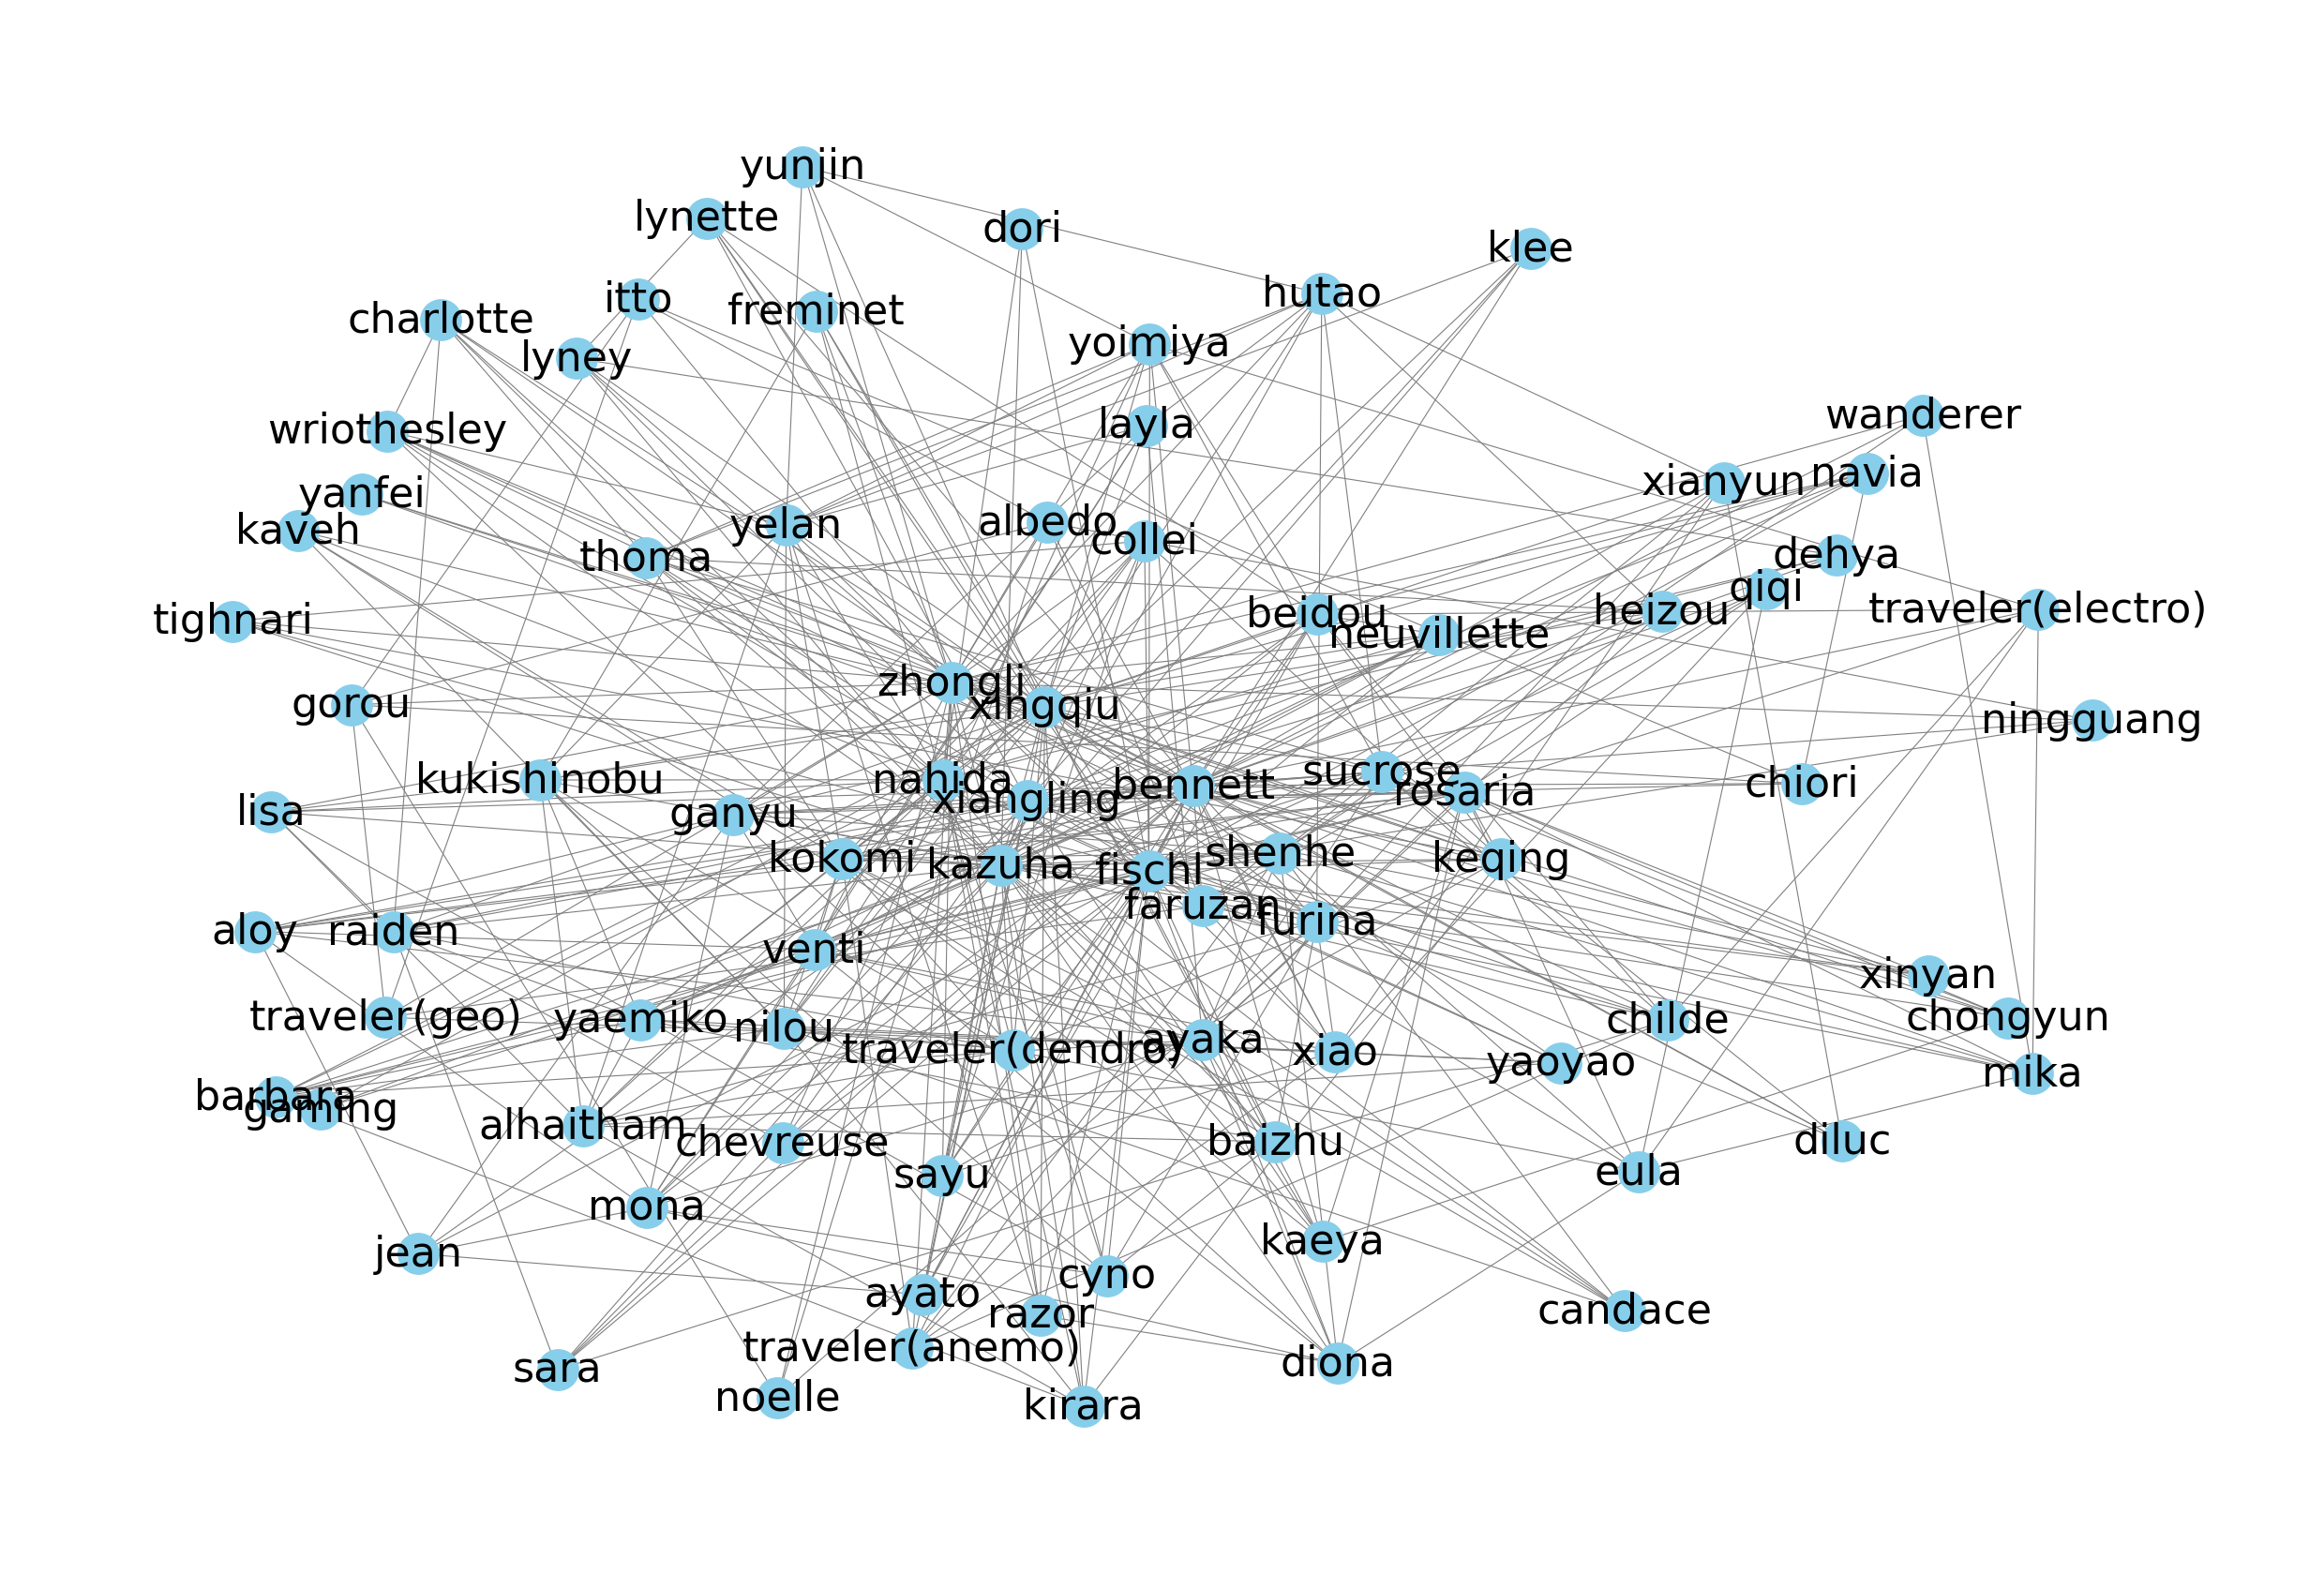

In [69]:
g = nx.Graph()
g.add_nodes_from(charlist)


for c1 in charlist: 
  for c2 in db[c1] : 
    g.add_edge(c1 , c2)


pos = nx.spring_layout(g, k=1.2)
plt.figure(dpi=400)

nx.draw(g, pos=pos ,with_labels=True , node_color='skyblue', node_size=50, width=0.2, font_size=8, edge_color="gray")
